# Week 5: Data Ingestion (Kafka)


![](https://camo.githubusercontent.com/56166d361c3975dee750ecce16d605bbbf66516b/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f352f35332f4170616368655f6b61666b615f776f7264747970652e737667)

### Student ID: [B96323]
### Subtasks Done: [1,2,3]

# Working with sensor data

We want to monitor the status of three smart buildings.
Each building has 8 floors and each floor has 20 rooms, that have a max capacity of 10 people each.

Rooms are equipped with sensors that counts how many people are currently inside the rooms. 

Due to COVID-19, we want monitor how many people are in the various rooms, floors, and buildings.

![](./buildings.png)

# Notes before starting!!!
 
- Look at the whole notebook (tasks) before starting
    - (Hint: task 2 and 3 depends on 0 and 1)
- you can create as many topics as you want 
    - (Hint 3 or more)
- each topic in the exercise should have **at least** 2 partitions. 
    - (HINT: to decide how many partition look at task 3)
- we assume a replication factor of 1 for all the topics is sufficient.
- The minimal required dependencies have been already imported.

## Task 0: Setting the environment

In [4]:
# !pip install confluent_kafka
# !pip install uuid

In [2]:
from confluent_kafka import SerializingProducer, DeserializingConsumer
from confluent_kafka.serialization import StringSerializer, StringDeserializer
from confluent_kafka.serialization import IntegerSerializer, IntegerDeserializer
from confluent_kafka.admin import AdminClient, NewTopic
from uuid import uuid4
import sys, lorem, random, time, json, csv

brokers = "kafka1:9092,kafka2:9093"
topics = ["topic1", "topic2", "topic3"] ## Add here your topics

In [19]:
# Config
conf = {'bootstrap.servers': brokers}
a = AdminClient(conf)
md = a.list_topics(timeout=10)
print(" {} topics:".format(len(md.topics)))
for t in iter(md.topics.values()):
    if t.error is not None:
        errstr = ": {}".format(t.error)
    else:
        errstr = ""
    print("  \"{}\" with {} partition(s){}".format(t, len(t.partitions), errstr))

 11 topics:
  "test2p" with 2 partition(s)
  "sentences1" with 2 partition(s)
  "_schemas" with 1 partition(s)
  "avro_topic" with 2 partition(s)
  "test1p" with 1 partition(s)
  "__consumer_offsets" with 50 partition(s)
  "string_topic" with 2 partition(s)
  "_confluent-metrics" with 12 partition(s)
  "words" with 2 partition(s)
  "lengths" with 2 partition(s)
  "__confluent.support.metrics" with 1 partition(s)


####  Create new topics

In [20]:
## Your topic Code Here
new_topics = [NewTopic(topic, num_partitions=2, replication_factor=1) for topic in topics]

In [21]:
fs = a.create_topics(new_topics)

In [22]:
# Delete Topics
ds = a.delete_topics([topics[0], topics[1], topics[2]], operation_timeout=30)
for topic, f in ds.items():
    try:
        f.result()  # The result itself is None
        print("Topic {} deleted".format(topic))
    except Exception as e:
        print("Failed to delete topic {}: {}".format(topic, e))

Topic topic1 deleted
Topic topic2 deleted
Topic topic3 deleted


In [23]:
for topic, f in fs.items():
    try:
        f.result()  # The result itself is None
        print("Topic {} created".format(topic))
    except Exception as e:
        print("Failed to create topic {}: {}".format(topic, e))

Topic topic1 created
Topic topic2 created
Topic topic3 created


## Task 1: Counting People

Write a Kafka Producer that generates the observations every 5 seconds (system time)
for each building, floor, and room, and pushes them to a topic.

We recommend "murmur2_random" as partitioner.

#### Populate the topics with 1000 observations

In [52]:
pconf = {
    'bootstrap.servers': brokers,
    ## Your Producer Configuration Code Here
    'partitioner': 'murmur2_random',
    'key.serializer': StringSerializer('utf_8'),
    'value.serializer': StringSerializer('utf_8')
}

In [53]:
## Your Producer Code Here
p = SerializingProducer(pconf)

#### Populate a topic with the 1000 observations in obs.csv, sending one every 5 seconds (system time)

#### Hints:
- represent the message as a json
- use the a random key (check the json)

In [54]:
f = open('obs.csv', 'r')

In [55]:
with f:
    print(next(csv.reader(f)))

['UUID', 'COUNT', 'BUILDING', 'FLOOR', 'ROOM']


In [56]:
f = open('obs.csv', 'r')
with f:
    reader = csv.reader(f)
    for n in range(1,1000):
        for row in reader:
            try:
            ## Your  Code Here
                print(row)
                p.produce(topic=topics[0], key=str(uuid4()), value=str(row))
                p.poll(0)
                p.flush()
            except KeyboardInterrupt:
                sys.stderr.write('%% Aborted by user\n')
            except BufferError:
                sys.stderr.write('%% Local producer queue is full (%d messages awaiting delivery): try again\n' % len(p))

['UUID', 'COUNT', 'BUILDING', 'FLOOR', 'ROOM']
['dae9bef5-1edc-496d-8bb4-dd63906546b8', '5', '0', '1', '13']
['fcb8180a-377c-4e52-b032-1384a3b0b9c4', '2', '1', '6', '8']
['3263b63d-a202-476e-9caa-e78edbe66d8d', '7', '2', '1', '12']
['79b7585c-c56a-46c9-8278-b6935fb89c62', '3', '0', '6', '11']
['df8d5082-c8e4-412b-888a-3292064b926e', '8', '0', '5', '15']
['9b19ffb8-33b8-4df5-bc84-3ae4880c759f', '6', '2', '5', '12']
['e0207da1-2ff9-419b-a8a7-7f2559e95611', '4', '1', '5', '14']
['fdfa60a8-47e3-455d-bee4-76a0b0802112', '2', '0', '4', '9']
['d5ca2db7-c2a2-4a9e-ace5-ff520fae4dad', '4', '0', '4', '16']
['954215bf-cfc3-43ae-a70b-bb030d15fd68', '3', '1', '5', '13']
['37de8704-5db6-42db-9391-18446f54c5ca', '3', '0', '6', '9']
['634b3010-2a60-427b-a086-31e7a6e261fe', '8', '2', '6', '18']
['57473145-4e9d-4451-931f-5bf5ac0d26da', '6', '2', '6', '14']
['2afd174f-d46c-4de0-8ebb-cc540fa11ac7', '2', '0', '4', '5']
['edd6ba0d-a000-428d-a70a-1723d6dc15d4', '2', '2', '7', '15']
['2e6fe083-25f4-472e-96a3-4

['7dbed679-7838-4490-83c1-d72dcfa77fde', '3', '2', '0', '0']
['2c8eb408-95e1-4e22-9ee8-4ca38d7c7e1c', '8', '2', '1', '7']
['fac8c1a2-acf9-4fdb-845b-2ffa87313793', '9', '2', '3', '13']
['bd4793cc-66ce-4cda-a1db-6b0a4e9156e4', '9', '1', '3', '15']
['d3da5771-4ca2-46c1-ae9a-068bf2fde52c', '8', '0', '6', '10']
['334be3e1-43e5-43f9-b34a-07d212a4d280', '9', '2', '3', '16']
['10bab532-b948-47ef-80d9-dec25d71c52c', '8', '0', '0', '13']
['48425023-4fc2-4d60-b585-774c7baeeabc', '8', '0', '3', '15']
['dce49f55-e82b-48ee-891a-1fbecd7bddb5', '8', '0', '5', '10']
['a3d51a88-45b8-4b93-8db4-cb2315f818f0', '1', '1', '3', '19']
['ceb0e2e2-132a-4a52-bda2-d94ea033d81d', '7', '0', '1', '17']
['63e5663b-17bf-4ff3-b67a-c15fa97e0042', '9', '2', '4', '18']
['1c177536-8649-4382-acab-e8f3a8b849d8', '8', '2', '6', '19']
['720d756a-4261-4682-88bd-99cd98b867c2', '2', '0', '6', '13']
['f19386f7-dbbd-49c3-bf18-0e14a9505813', '9', '0', '0', '18']
['5b4f847b-be4e-4657-8cd6-cbe8c3be5e43', '1', '0', '2', '6']
['842f1f21-

['c1db1073-de2a-4224-9982-407293cfb974', '5', '0', '7', '5']
['c8eae414-833b-4ed9-9b77-4f5bc0927649', '7', '1', '5', '17']
['21e540f6-3c54-4037-98d7-ea4ed1cc790b', '7', '0', '1', '8']
['95ee3fd7-679b-4f62-8ef7-b00a4b4a92b9', '6', '1', '3', '0']
['436f5ded-fd92-4bd6-8c74-50f96e4c2ca9', '2', '1', '4', '4']
['f235f674-6490-443c-884e-f5d9090975c6', '6', '1', '6', '3']
['a78addc8-d50b-4f34-b67a-331789bef07d', '9', '0', '3', '13']
['54a4bbc8-a034-404e-b2a7-87cd024ff845', '0', '2', '4', '12']
['ee0ad94b-710f-4835-b8c0-f1e1f11b803a', '3', '0', '1', '1']
['c0876962-3fe5-4671-a915-7e952972bf78', '3', '1', '4', '0']
['7e4a8b88-e30e-4b59-a7de-521205caf7ac', '0', '1', '1', '1']
['19513f54-8e3f-4e5d-acc5-50586875610a', '7', '0', '0', '6']
['66be367e-e120-4b90-98fa-586fd737c967', '9', '0', '2', '7']
['caf6ae4c-3599-4ff6-a76b-2db9b4854b21', '4', '2', '3', '4']
['72058e31-8383-4d50-bf82-b36a95265889', '5', '1', '5', '13']
['57274431-7899-4fa5-93b3-dfc943be77a2', '5', '2', '0', '8']
['ab0d5aad-1e21-49c8

['8b4ddda3-16f3-4c6e-9cc1-9eee89a64991', '2', '0', '0', '17']
['81af75da-3ecc-4e5d-a677-33d81c4bbe18', '6', '2', '5', '7']
['075c9248-244b-4a26-adcd-7110424559a9', '9', '0', '7', '9']
['b9f62146-b7bc-4f9a-831d-c1a2524c6ca2', '2', '0', '2', '6']
['2de4e04b-0af8-486b-b6d0-11b1b2499927', '8', '0', '6', '4']
['bc331b02-a523-413c-947b-48af7426af55', '0', '2', '7', '8']
['1c615e77-8eff-4088-88d0-bf3ddf784abd', '7', '2', '4', '17']
['644ddc21-3845-47ec-bd67-2a88eee84bce', '2', '2', '6', '1']
['41f73c56-1ab8-4ce9-a011-a92325172628', '6', '1', '4', '10']
['ffb6b0e3-1ebd-4d5b-8e87-e7c9d1aaf0c1', '6', '0', '5', '6']
['3e240868-9dd9-4906-bb23-1cf796b9139c', '4', '1', '0', '10']
['c9990e39-c7f9-4f07-89a3-a3d40c439fb3', '8', '2', '6', '0']
['9e1b023f-d3b0-45f9-8d00-b3696d17e373', '5', '2', '5', '7']
['1eb0ae60-3c63-4245-b77e-0cd624f488a4', '0', '0', '2', '6']
['9f61e5f4-37de-49b8-9d10-96106a7962ff', '1', '1', '7', '13']
['cbd77939-9255-4987-9a30-13b6aa953e2d', '8', '0', '5', '15']
['df0f30b9-8ed0-4f

['4391df68-ddcd-41e2-8f7b-ef660cc431a5', '9', '2', '5', '16']
['fbd0d362-343b-4ad9-8f90-85c4d31d486f', '2', '1', '3', '16']
['48ca27e3-0288-426e-874a-3f194d3a0e49', '9', '0', '1', '13']
['355c19dd-a8a1-4532-a4ee-98b1b0bf2e3a', '9', '2', '5', '11']
['40d642c4-f91e-4172-81a8-22938a1e2a34', '0', '1', '3', '0']
['3e1f5000-f5d3-4b03-bd2b-c84ec4054dc6', '6', '2', '0', '9']
['0b5c3f20-0e72-4c26-9bd1-f179052c4574', '1', '2', '6', '0']
['9a864cfe-6ef8-4747-bc43-b1b10028834d', '5', '2', '6', '2']
['15adccd7-ad17-45b5-a61d-ed21b8787c23', '7', '0', '6', '16']
['29ed2476-b3b6-4ee8-bcd4-4dc7a8598f3c', '4', '2', '3', '12']
['0130ac38-9d5a-48a9-ae34-eed48bd0109d', '0', '1', '6', '4']
['477239b2-a3c6-478b-8219-37d3769f4dc2', '7', '2', '1', '5']
['565b42b3-8923-4f9f-bf0b-1b9c365aff20', '9', '0', '3', '16']
['dc611cf5-d479-41f2-bd55-de7203e23242', '5', '0', '5', '9']
['094857c3-5a8a-4b7e-b26c-013252b9a3c4', '9', '2', '2', '17']
['066d8a9b-d3ff-46c5-8e83-3ede0d6f9f11', '2', '2', '3', '19']
['749a2ecd-6f10

['4b53c02c-9389-43fc-93c1-02ba680963b4', '1', '0', '5', '9']
['ed4369c4-ecde-4254-9477-efb6aa4425f3', '7', '0', '5', '4']
['5f988e23-acd6-4b2e-8388-9379ba6526ed', '8', '1', '7', '7']
['54c05592-fd5a-4c85-bdf0-b8fd084233c3', '3', '0', '5', '5']
['96eb296e-ab4e-47b7-8a5f-293a3df27a63', '0', '1', '4', '5']
['1a67ae69-8e14-4771-a30c-0fbb7d00dfef', '0', '0', '0', '15']
['ad08a7b6-ce0f-46d2-960b-89c1e5fc3053', '5', '2', '5', '15']
['b7d81688-fdeb-4fe0-9432-daf41db1bc37', '6', '2', '4', '5']
['2c6c6efb-ef09-492a-8791-2fe5502721fb', '4', '1', '6', '6']
['4f113dfa-f1f8-4daa-ad2a-ace2c38b34b7', '3', '1', '0', '5']
['c8782977-76d7-4e29-a61f-7eee61e5349d', '0', '1', '5', '18']
['5f3832b5-fcbf-4db1-b2c9-1aa770fde72d', '6', '0', '4', '9']
['271cabdd-1a06-441c-b0df-e9f014e40433', '4', '2', '4', '0']
['2c6f8ba2-3c6e-40c9-bf0c-32555d2338a3', '1', '2', '1', '1']
['bef62990-8318-43a0-a193-ee331447a6d1', '7', '2', '0', '16']
['88959d49-ab71-4d7e-98d8-b76f721bd3a6', '8', '2', '5', '18']
['f40118b4-62bc-4d4

['a8a370d9-6a6d-42ac-ad02-b0cc564713c4', '4', '0', '6', '5']
['5dc5d14e-875d-4a16-8d78-fed73a09a964', '2', '1', '0', '0']
['6da7bb4c-4e0d-4a2e-8366-6c8b8fd7ce55', '3', '0', '5', '5']
['a3e6293d-57a4-4f61-970f-49df2fa01865', '0', '1', '6', '19']
['3aaa2109-23a4-4a84-90e3-bc2e74007845', '9', '2', '7', '14']
['ab1ab04b-8b8f-423d-980b-ecd3f94b5509', '4', '1', '3', '0']
['704f5573-920e-4e9d-bdbf-1ace0396f92b', '2', '1', '7', '0']
['6db60fca-4261-463e-a8d1-23ebd0289d7e', '0', '0', '1', '8']
['2eba2b2b-c572-4198-8982-bdeb86263397', '3', '2', '0', '5']
['f902d297-bd05-444c-be19-489f22d50104', '7', '0', '1', '9']
['2f349c0c-afb4-4453-b19b-bb06c5fcacd7', '1', '1', '2', '8']
['d21ad56a-4f32-48d5-a378-df6c746e3c14', '0', '1', '0', '11']
['a8c08390-aaad-4cbd-92c6-f23e8e8d434e', '5', '0', '0', '7']
['ffbfe395-4363-458f-8d92-60fc5cf02106', '4', '0', '3', '4']
['5ed203d0-fb4a-4313-ac9d-b4a4fc229153', '2', '1', '1', '11']
['b3fb82a9-80eb-41cf-ba9c-e0b01898dbf3', '7', '0', '5', '10']
['1fb15675-4108-4b5

In [25]:
# original
f = open('obs.csv', 'r')
with f:
    reader = csv.reader(f)
    for n in range(1,1000):
        for row in reader:
            try:
            ## Your  Code Here
                print(row)
                p.produce(topic=topics[0], key=str(uuid4()), value=str(row))
                p.poll(0)
                p.flush()
            except KeyboardInterrupt:
                sys.stderr.write('%% Aborted by user\n')
            except BufferError:
                sys.stderr.write('%% Local producer queue is full (%d messages awaiting delivery): try again\n' % len(p))

['UUID', 'COUNT', 'BUILDING', 'FLOOR', 'ROOM']
['dae9bef5-1edc-496d-8bb4-dd63906546b8', '5', '0', '1', '13']
['fcb8180a-377c-4e52-b032-1384a3b0b9c4', '2', '1', '6', '8']
['3263b63d-a202-476e-9caa-e78edbe66d8d', '7', '2', '1', '12']
['79b7585c-c56a-46c9-8278-b6935fb89c62', '3', '0', '6', '11']
['df8d5082-c8e4-412b-888a-3292064b926e', '8', '0', '5', '15']
['9b19ffb8-33b8-4df5-bc84-3ae4880c759f', '6', '2', '5', '12']
['e0207da1-2ff9-419b-a8a7-7f2559e95611', '4', '1', '5', '14']
['fdfa60a8-47e3-455d-bee4-76a0b0802112', '2', '0', '4', '9']
['d5ca2db7-c2a2-4a9e-ace5-ff520fae4dad', '4', '0', '4', '16']
['954215bf-cfc3-43ae-a70b-bb030d15fd68', '3', '1', '5', '13']
['37de8704-5db6-42db-9391-18446f54c5ca', '3', '0', '6', '9']
['634b3010-2a60-427b-a086-31e7a6e261fe', '8', '2', '6', '18']
['57473145-4e9d-4451-931f-5bf5ac0d26da', '6', '2', '6', '14']
['2afd174f-d46c-4de0-8ebb-cc540fa11ac7', '2', '0', '4', '5']
['edd6ba0d-a000-428d-a70a-1723d6dc15d4', '2', '2', '7', '15']
['2e6fe083-25f4-472e-96a3-4

['af7aef87-a4de-4c8f-a7e5-639b6b227af8', '6', '0', '2', '2']
['fd991fb6-09fc-4e89-be12-8cc3e4c5b348', '6', '0', '7', '4']
['06765458-f6ba-4b66-ade2-b1b624b30cc3', '9', '1', '0', '4']
['0df73f08-1b7d-46a3-b044-a655dcff7823', '0', '0', '1', '14']
['5c17ccf4-8a8a-47e9-aef4-dff32bdbe70f', '7', '2', '2', '6']
['660a23f9-80dd-439a-b73d-0644dd56d8cd', '2', '2', '5', '13']
['0ec7a78c-5e2d-45a7-a5fb-9a888353b161', '2', '1', '1', '5']
['0ec1986b-b565-487b-a3a7-64c66d5fe905', '9', '1', '0', '1']
['77a667ba-c291-40f9-8f80-15f5775aac7b', '9', '1', '3', '10']
['f18cbd95-5eae-400c-bcf3-6ea17df16ce6', '7', '2', '1', '6']
['7dbed679-7838-4490-83c1-d72dcfa77fde', '3', '2', '0', '0']
['2c8eb408-95e1-4e22-9ee8-4ca38d7c7e1c', '8', '2', '1', '7']
['fac8c1a2-acf9-4fdb-845b-2ffa87313793', '9', '2', '3', '13']
['bd4793cc-66ce-4cda-a1db-6b0a4e9156e4', '9', '1', '3', '15']
['d3da5771-4ca2-46c1-ae9a-068bf2fde52c', '8', '0', '6', '10']
['334be3e1-43e5-43f9-b34a-07d212a4d280', '9', '2', '3', '16']
['10bab532-b948-4

['f07b5273-df74-4804-95ff-a22dcd9082de', '3', '0', '7', '14']
['a51f7ee2-2de9-4ce4-8883-bfefe6514a53', '8', '2', '5', '14']
['17519ee7-7b5e-4427-bcf4-2ac0b275b541', '5', '0', '2', '13']
['b50623da-6196-43b0-a19b-a611ee824b74', '7', '0', '3', '19']
['3c730002-ac2f-4dff-b896-d778e35b7516', '7', '2', '3', '8']
['5640a15e-f143-4f47-86d1-23e644e18df1', '9', '1', '4', '3']
['f4faf795-229f-4532-a4d7-3e8a4027fb52', '6', '0', '5', '4']
['155ad45b-1245-4ea3-ad7f-06a21f9ba5b7', '0', '2', '7', '5']
['e2d55ee2-7358-41f4-91af-d1da792fb91f', '9', '0', '2', '19']
['10a64765-2f33-4dd0-90f0-8e99f6ec53b8', '2', '1', '7', '16']
['468a4ad0-32ae-4931-ba4e-a71a8d8263d0', '5', '1', '2', '15']
['688019c3-68ba-4577-a9cc-23c522b0aa4d', '4', '0', '2', '16']
['1f8a1273-7422-4db2-84dc-03c331e28fcc', '4', '0', '2', '9']
['988528a0-c5a5-486c-9b83-c4ad35d167f9', '9', '1', '5', '3']
['e06ab573-944d-41ec-8550-85b182b0c6c8', '0', '1', '1', '16']
['07e3bf78-6c62-4b16-b57d-d13d8743929c', '4', '2', '1', '11']
['0085071a-98e

['2eacb10e-3b95-4dff-a947-46308c0a5abb', '1', '1', '1', '1']
['efa33dde-bd19-432e-b831-1efb2c1cd1cd', '8', '2', '5', '2']
['619cf346-7640-41c7-b274-093562406cbd', '6', '1', '6', '3']
['f01f0f18-061d-4ac7-96b6-45dbb2b29a44', '0', '0', '3', '10']
['d0965ed5-f9ab-4e06-b249-e86c26f91322', '3', '0', '1', '15']
['da866b32-472f-4824-aed5-cb6e55848661', '4', '2', '4', '7']
['52100206-4f2a-42d7-add9-85cc62e3b314', '3', '1', '7', '7']
['b428c0c7-a1ec-4e33-b1ab-50ca424c283f', '2', '0', '4', '8']
['043d4fce-4c56-46ef-9257-17022ae003b4', '6', '0', '6', '13']
['952c7e67-8a88-4f31-8c75-160ea10f3994', '4', '1', '7', '12']
['6aca944c-ad76-4a51-8177-ff131f70e992', '0', '0', '3', '2']
['a188050f-c260-4d25-a226-3e1c7701b6c4', '1', '0', '1', '19']
['f7dd6835-e774-4221-bae5-b306f113119c', '4', '1', '7', '2']
['d41020fe-b812-4a6b-8e79-488a86776b33', '7', '1', '0', '19']
['7a75a6ff-b673-4d58-8f88-f85c2604aa56', '2', '0', '3', '10']
['b11ab9c9-24b1-44ff-bddc-66a0c4b7bff5', '1', '0', '5', '5']
['f55613ee-7954-4

['53d800a9-d2b5-4e9f-8f62-64ce0ac3de17', '3', '0', '5', '2']
['022e5fac-3952-4fa7-a556-0c0ba0531509', '2', '1', '4', '7']
['de6fce90-d7bc-4c93-8001-cf7ef77e9557', '0', '2', '2', '14']
['970dc3a8-3918-4a48-8bb9-3a7e3a5d83a3', '4', '0', '6', '19']
['ac513145-4f30-4690-b8dd-cf97ded13865', '6', '0', '2', '19']
['3947ce95-b754-44dc-893d-93c2070972d6', '9', '0', '6', '10']
['3e5a84f0-d971-4d68-a287-7d00db8a510f', '2', '1', '2', '17']
['ec4ef713-1500-4fa5-a231-616a91a8f42b', '9', '1', '5', '0']
['47ad5739-f319-4de3-bda9-eb8d1344eff6', '1', '2', '7', '16']
['b07a20e8-fcce-44e7-bc2c-7c2e07188c79', '2', '1', '1', '15']
['f155b345-f50a-4866-b764-0874edb454c2', '2', '0', '0', '4']
['d655a1a2-d5f0-46fd-be97-4fc5f3271dc0', '6', '2', '1', '5']
['c8f2d9c7-5a68-47b6-8f87-362e5a67c625', '2', '1', '1', '10']
['37f05499-f290-4edb-b9fa-de8766557d50', '9', '0', '4', '0']
['f02a8d31-aa1c-4aed-987f-6c198a0725f5', '3', '2', '4', '0']
['8079a195-a39a-4d35-88d5-f409505bd01a', '0', '2', '5', '2']
['1bcf416c-b2c8-

['7b9a8c8e-3c63-4a9d-beff-053dc3211097', '7', '1', '6', '11']
['0b8246a9-da53-4ee2-b5e6-44ce336b8272', '8', '0', '4', '15']
['c37fa362-db2e-42f5-bd25-e95b1781e3f4', '4', '1', '5', '11']
['c0ba7b8b-e28a-43c6-86d3-6f792e037c00', '8', '1', '7', '9']
['00b3bf53-8e4a-4bd9-b52c-40803ca4aa6b', '5', '0', '5', '17']
['a1ab850f-daae-419d-a42c-6fcc732d02a1', '3', '1', '4', '1']
['be63d8b0-4d80-471e-9aee-e4d9fed7190a', '6', '1', '0', '1']
['8dfc87b5-cedd-4806-b470-a581f90a3737', '7', '2', '0', '5']
['350ed97e-8eba-4272-b8b2-82f3b6165e48', '0', '2', '3', '5']
['bee72dc0-8dbc-4344-8e11-367246e4ebe0', '2', '1', '0', '15']
['564e36df-6353-4e2a-a2f3-a818d799a8dc', '9', '1', '6', '6']
['6a1729ae-3586-4bab-832f-ac6fc3a3ea75', '2', '0', '3', '8']
['6c21f224-4b53-4789-929e-4dce834ac8e0', '2', '1', '7', '4']
['47efcd50-d554-4960-8c43-f3afa5b8f4a7', '0', '1', '0', '5']
['a4f5db6b-2bca-4776-b3b6-226e55364a1a', '5', '0', '7', '10']
['4b2a7253-7675-41fa-9c4f-795c140c5890', '7', '0', '2', '5']
['493e96fb-f220-48

['68a9f4d1-a11f-4bae-a561-2463cf7b13d2', '8', '2', '1', '18']
['2130b4f2-a078-462f-a4fd-6991a92a8ed5', '7', '1', '2', '10']
['4cb4763a-99c0-438a-bfd1-a84afd734750', '2', '1', '2', '7']
['dd9a2f5c-3f99-422d-8dfa-31488412c2e2', '9', '1', '1', '3']
['3249992f-459f-4efd-8e10-373caa1feeb0', '3', '1', '2', '6']
['16c8dda3-c44e-4bf9-9088-c305a6a42928', '4', '0', '2', '0']
['3601559a-bd87-49b0-835a-71f0f82302cf', '0', '2', '3', '14']
['f5c08ebb-4fd0-4331-9a58-2989d7a5ea12', '0', '2', '1', '5']
['01966f8c-5608-4baa-b312-8071fd2329f6', '4', '2', '5', '0']
['fb0b088e-7ac6-40dc-8a71-0dba370ee63e', '9', '0', '5', '10']
['ddc210b6-b6d6-4dff-b711-37be64d63aa4', '6', '1', '3', '13']
['54bf2854-f06b-416e-899e-fee34633e906', '1', '1', '6', '11']
['2f50238c-895b-4252-8283-edc00fed5f76', '8', '0', '1', '15']
['5f59df43-7610-44d1-a4bd-9cff4b296d1d', '5', '1', '5', '11']
['68a29ee3-e867-4575-8505-a78e58fb5492', '5', '0', '7', '7']
['ecc0064c-c97a-4e7c-aece-a2ef3baced59', '4', '2', '0', '3']
['372c592d-ae57-

['983b9247-48b0-4015-a2d7-05aa7d12b8ae', '2', '2', '4', '6']
['1717c8f7-939a-48bc-9a5f-b8e74a37128c', '5', '2', '1', '14']
['e1e95264-9fa8-4e9a-8352-095b08b30edf', '3', '0', '0', '15']
['510fbff5-fc4f-4155-ad50-0a2abafd2d36', '4', '0', '0', '17']
['3c7ee4f1-bf73-4c79-ad64-3dfa67f75647', '9', '1', '7', '13']
['0ff48b59-0211-4755-9c96-fde93b647236', '3', '1', '6', '9']
['4ba27137-c563-46c2-974e-3351f8b76739', '3', '1', '3', '19']
['9273091e-33ad-492b-a313-31927e49fb78', '5', '2', '5', '2']
['03152b83-d1b0-4381-9ce6-f921ba8e1144', '4', '0', '7', '0']
['c9c3640b-15c8-40d4-9f1c-8d8991ff6560', '2', '0', '6', '9']


## Task 2: Reading observations

Write a Kafka Consumer that reads the previous topic and prints the result out.

In [27]:
string_deserializer = StringDeserializer('utf_8')

In [28]:
consumer_conf = {
    'bootstrap.servers': brokers,
    ## Your Configuration Code Here
    'key.deserializer': string_deserializer,
    'value.deserializer': string_deserializer,
    'group.id': str(uuid4()), # correspond to the name of consumer groups
    'session.timeout.ms': 6000,
    'auto.offset.reset': 'earliest'
}

In [28]:
## Your CONSUMER Code Here
c = DeserializingConsumer(consumer_conf)
c.subscribe([topics[0]])
# topics[0]

#### Consume 1000 observations

In [29]:
import sys
try:
    for i in range(0,1000):
        ## Your consuming Code Here
        # SIGINT can't be handled when polling, limit timeout to 1 second.
        msg = c.poll(timeout = 1.0)
        if msg is None:
            continue
        if msg.error():
            raise KafkaException(msg.error())
        else:
            print("{} [{}] at offset  {} with key  {}:  {}".format(msg.topic(), msg.partition(), msg.offset(), str(msg.key()), str(msg.value())))
#             print("{} [{}]".format(msg.topic(), msg.partition()))
#             print(msg.value)

        
except KeyboardInterrupt:
    sys.stderr.write('%% Aborted by user\n')
finally:
    # Close down consumer to commit final offsets.
    c.close()

topic1 [1] at offset  0 with key  788974fa-fb91-4faa-abec-243222a86059:  ['3263b63d-a202-476e-9caa-e78edbe66d8d', '7', '2', '1', '12']
topic1 [1] at offset  1 with key  4874a0d2-b4ec-4c1b-868c-036e0ac6343d:  ['79b7585c-c56a-46c9-8278-b6935fb89c62', '3', '0', '6', '11']
topic1 [1] at offset  2 with key  6d110ca6-ca7f-419a-9aed-b9b6f823cf52:  ['df8d5082-c8e4-412b-888a-3292064b926e', '8', '0', '5', '15']
topic1 [1] at offset  3 with key  bd36d55b-5652-4e10-8162-ecf349923521:  ['9b19ffb8-33b8-4df5-bc84-3ae4880c759f', '6', '2', '5', '12']
topic1 [1] at offset  4 with key  c54357d4-bef2-4416-a790-924c9acf3ccf:  ['fdfa60a8-47e3-455d-bee4-76a0b0802112', '2', '0', '4', '9']
topic1 [1] at offset  5 with key  cd935f49-7d01-4b19-9ec4-0afb87742fc6:  ['954215bf-cfc3-43ae-a70b-bb030d15fd68', '3', '1', '5', '13']
topic1 [1] at offset  6 with key  4d23a74e-957c-45cd-be9d-a4f0dd7d2e51:  ['2e6fe083-25f4-472e-96a3-4d745107d72d', '7', '0', '6', '0']
topic1 [1] at offset  7 with key  57a50a4b-20a6-4b34-8889

## Task 3: Aggregating the number of people 

Write a Kafka Consumer that reads the previous topics and count
the number of people per floor and per building every minute,

Always ensure the result are durable (save them in a topic)

Carry on the minimal ammount of information in the key and the value (remove unnecessary information)




##### HINT: How did you organize the data in partitions?

#### Change the message key to simplify counting by floor.

In [170]:
from confluent_kafka.serialization import IntegerSerializer, IntegerDeserializer

consumer_conf['group.id'] = str(uuid4())
c2 = DeserializingConsumer(consumer_conf)
c2.subscribe([topics[0]])

pconf = {
    'bootstrap.servers': brokers,
    'key.serializer': StringSerializer('utf_8'),
    'value.serializer': IntegerSerializer()
}


p2 = SerializingProducer(pconf)

In [172]:
try:
    f = open('obs_without_header.csv', 'r')
    with f:
        reader = csv.reader(f)
        for n in range(1,1000):
            for row in reader:
            ## Your  Code Here
                print(row[3], row[1])
                p2.produce(topics[1], key=str(row[3]), value=int(row[1]))
                p2.poll(0)
                p2.flush()

except KeyboardInterrupt:
    sys.stderr.write('%% Aborted by user\n')
finally:
    # Close down consumer to commit final offsets.
#     c2.close()

In [33]:
consumer_conf['group.id'] = str(uuid4())
consumer_conf['value.deserializer'] = IntegerDeserializer()

words = {}

In [34]:
c3 = DeserializingConsumer(consumer_conf)
c3.subscribe([topics[1]])

In [175]:
try:
    while True:
        # SIGINT can't be handled when polling, limit timeout to 1 second.
        msg = c3.poll(1.0)
        if msg is None:
            continue
        if msg.error():
            raise KafkaException(msg.error())
        else:
            w = msg.key()
            print(w)
            if w in words:
                words[w] = words[w] + msg.value()
            else:
                words[w] = msg.value()
except KeyboardInterrupt:
    sys.stderr.write('%% Aborted by user\n')
finally:
    # Close down consumer to commit final offsets.
    c3.close()

1
6
1
6
5
5
5
4
4
5
6
6
6
4
7
6
1
0
7
6
0
6
4
6
6
2
3
6
2
4
1
0
5
2
3
3
7
3
1
3
0
6
2
6
6
0
0
2
0
5
2
2
2
6
6
6
1
4
5
1
1
3
5
2
0
3
6
2
4
3
4
4
6
7
6
3
4
3
4
2
6
2
3
7
5
2
6
2
2
4
5
3
0
4
6
0
6
6
2
5
4
3
4
2
6
2
6
7
1
6
1
4
6
4
7
0
0
0
6
2
6
1
5
4
5
3
4
3
5
0
2
7
0
2
7
0
1
2
5
1
0
3
1
0
1
3
3
6
3
0
3
5
3
1
4
6
6
0
2
0
1
0
4
7
4
1
1
7
4
5
3
6
2
4
0
5
7
6
6
5
3
4
0
7
0
6
1
6
4
7
5
5
5
5
3
3
5
3
5
4
1
1
3
7
1
0
2
4
5
6
1
6
3
1
1
7
7
7
2
3
3
3
5
5
1
6
1
6
7
5
6
5
1
0
3
1
2
1
0
6
2
7
2
7
2
1
4
1
6
2
4
5
7
7
4
0
2
2
5
1
5
4
7
6
3
1
4
1
6
7
7
7
0
0
5
7
5
2
3
3
4
5
7
2
7
2
2
2
5
1
1
6
7
5
1
3
4
6
3
4
1
4
1
0
2
3
5
0
7
4
2
5
7
5
0
0
2
5
0
2
2
4
2
1
0
7
2
6
2
6
5
7
7
1
5
1
1
7
0
2
5
6
5
1
5
1
7
7
1
2
0
7
7
4
4
1
3
7
7
3
1
0
6
6
0
0
5
5
4
4
2
4
1
6
7
2
7
3
0
6
3
5
6
6
7
5
5
3
1
7
7
0
0
0
3
4
4
1
6
7
7
2
3
2
0
0
7
1
4
7
7
0
1
5
6
3
1
4
7
4
6
7
3
1
7
0
3
5
6
1
4
3
4
1
5
2
0
3
2
1
6
5
2
6
0
5
7
2
6
7
4
6
4
5
0
6
5
2
7
5
3
2
2
1
6
3
3
0
0
3
2
6
1
5
0
2
4
3
6
2
7
2
7
4
5
0
4
6
2
2
1
6
3
0
6
4
4
2
0
4


%% Aborted by user


In [176]:
words

{'1': 646,
 '6': 625,
 '5': 589,
 '4': 493,
 '7': 497,
 '0': 559,
 '2': 526,
 '3': 530}

### Total number of people Per Floor

keep the local count of people on each floor. Floor are uniquely identified by building and floor number. 

In [20]:
# consumer_conf = {
#     'bootstrap.servers': brokers,
#     ## Your configuration code here
# #     'key.deserializer': StringSerializer('utf_8'),
#     'value.deserializer': IntegerDeserializer(),
#     'group.id': str(uuid4()), # correspond to the name of consumer groups
#     'session.timeout.ms': 6000,
#     'auto.offset.reset': 'earliest'
# }

In [35]:
## Your Consumer Code Here
consumer_conf['group.id'] = str(uuid4())
consumer_conf['value.deserializer'] = IntegerDeserializer()

c3 = DeserializingConsumer(consumer_conf)
c3.subscribe([topics[1]])

### Use the following dictionary to maintain aggregate the results

In [31]:
floors = {}

In [30]:
pconf = {
    'bootstrap.servers': brokers,
    'key.serializer': StringSerializer('utf_8'),
    'value.serializer': IntegerSerializer()
}
p3 = SerializingProducer(pconf)

try:
    f = open('obs_without_header.csv', 'r')
    with f:
        reader = csv.reader(f)
        for n in range(1,1000):
            for row in reader:
            ## Your  Code Here
                key_string = 'building' + str(row[2])+ '_floor' + str(row[3])
                print(key_string, row[1])
                p3.produce(topics[1], key=key_string, value=int(row[1]))
                p3.poll(0)
                p3.flush()

except KeyboardInterrupt:
    sys.stderr.write('%% Aborted by user\n')

building0_floor1 5
building1_floor6 2
building2_floor1 7
building0_floor6 3
building0_floor5 8
building2_floor5 6
building1_floor5 4
building0_floor4 2
building0_floor4 4
building1_floor5 3
building0_floor6 3
building2_floor6 8
building2_floor6 6
building0_floor4 2
building2_floor7 2
building0_floor6 7
building0_floor1 0
building1_floor0 1
building2_floor7 3
building1_floor6 4
building2_floor0 9
building2_floor6 9
building1_floor4 0
building0_floor6 5
building2_floor6 1
building2_floor2 0
building0_floor3 6
building2_floor6 3
building0_floor2 0
building2_floor4 4
building0_floor1 4
building1_floor0 2
building0_floor5 6
building1_floor2 3
building0_floor3 1
building2_floor3 2
building1_floor7 0
building0_floor3 6
building2_floor1 6
building2_floor3 2
building2_floor0 9
building2_floor6 0
building0_floor2 3
building2_floor6 3
building1_floor6 0
building1_floor0 8
building2_floor0 4
building0_floor2 4
building2_floor0 0
building1_floor5 7
building0_floor2 3
building1_floor2 2
building1_fl

building0_floor6 0
building0_floor0 2
building2_floor5 6
building0_floor7 9
building0_floor2 2
building0_floor6 8
building2_floor7 0
building2_floor4 7
building2_floor6 2
building1_floor4 6
building0_floor5 6
building1_floor0 4
building2_floor6 8
building2_floor5 5
building0_floor2 0
building1_floor7 1
building0_floor5 8
building1_floor3 9
building0_floor2 6
building1_floor2 1
building2_floor1 0
building2_floor6 2
building2_floor3 6
building1_floor3 5
building0_floor0 1
building0_floor0 3
building1_floor3 1
building0_floor2 8
building1_floor6 8
building0_floor1 2
building0_floor5 4
building2_floor0 1
building0_floor2 3
building2_floor4 0
building2_floor3 3
building2_floor6 8
building1_floor2 5
building0_floor7 5
building1_floor2 2
building0_floor7 5
building0_floor4 8
building2_floor5 2
building1_floor0 6
building0_floor4 4
building0_floor6 3
building1_floor2 3
building0_floor2 7
building2_floor1 5
building2_floor6 0
building0_floor3 3
building2_floor0 9
building1_floor6 2
building1_fl

building2_floor7 3
building1_floor3 7
building0_floor1 4
building1_floor7 7
building1_floor0 7
building2_floor2 7
building0_floor2 3
building1_floor2 6
building1_floor6 2
building0_floor6 4
building1_floor0 2
building0_floor5 3
building1_floor6 0
building2_floor7 9
building1_floor3 4
building1_floor7 2
building0_floor1 0
building2_floor0 3
building0_floor1 7
building1_floor2 1
building1_floor0 0
building0_floor0 5
building0_floor3 4
building1_floor1 2
building0_floor5 7
building0_floor0 7
building2_floor4 3
building0_floor1 8
building0_floor6 6
building0_floor6 6
building0_floor3 1
building2_floor7 1
building0_floor4 6
building0_floor1 8
building0_floor4 4
building2_floor0 7
building2_floor4 1
building1_floor2 9
building2_floor1 4
building0_floor0 5
building0_floor5 8
building0_floor1 5
building1_floor0 8
building2_floor3 0
building0_floor7 1
building1_floor4 0
building1_floor0 8
building0_floor3 9
building2_floor6 6
building1_floor0 5
building1_floor6 4
building0_floor1 0
building2_fl

In [36]:
try:
    while True:
        # SIGINT can't be handled when polling, limit timeout to 1 second.
        msg = c3.poll(1.0)
        if msg is None:
            continue
        if msg.error():
            raise KafkaException(msg.error())
        else:
            f = msg.key()
            print(msg.key())
            print(msg.value())
            if f in floors:
                floors[f] = floors[f] + msg.value()
            else:
                floors[f] = msg.value()
except KeyboardInterrupt:
    sys.stderr.write('%% Aborted by user\n')
# finally:
#     # Close down consumer to commit final offsets.
#     c3.close()

b'1'
5
b'6'
2
b'1'
7
b'6'
3
b'5'
8
b'5'
6
b'5'
4
b'4'
2
b'4'
4
b'5'
3
b'6'
3
b'6'
8
b'6'
6
b'4'
2
b'7'
2
b'6'
7
b'1'
0
b'0'
1
b'7'
3
b'6'
4
b'0'
9
b'6'
9
b'4'
0
b'6'
5
b'6'
1
b'2'
0
b'3'
6
b'6'
3
b'2'
0
b'4'
4
b'1'
4
b'0'
2
b'5'
6
b'2'
3
b'3'
1
b'3'
2
b'7'
0
b'3'
6
b'1'
6
b'3'
2
b'0'
9
b'6'
0
b'2'
3
b'6'
3
b'6'
0
b'0'
8
b'0'
4
b'2'
4
b'0'
0
b'5'
7
b'2'
3
b'2'
2
b'2'
1
b'6'
1
b'6'
3
b'6'
9
b'1'
0
b'4'
6
b'5'
6
b'1'
4
b'1'
6
b'3'
4
b'5'
1
b'2'
3
b'0'
1
b'3'
5
b'6'
8
b'2'
1
b'4'
5
b'3'
7
b'4'
3
b'4'
6
b'6'
5
b'7'
0
b'6'
8
b'3'
5
b'4'
2
b'3'
3
b'4'
5
b'2'
4
b'6'
5
b'2'
8
b'3'
5
b'7'
6
b'5'
2
b'2'
5
b'6'
2
b'2'
7
b'2'
8
b'4'
9
b'5'
4
b'3'
7
b'0'
7
b'4'
2
b'6'
3
b'0'
2
b'6'
1
b'6'
6
b'2'
4
b'5'
5
b'4'
8
b'3'
6
b'4'
5
b'2'
0
b'6'
3
b'2'
0
b'6'
9
b'7'
7
b'1'
4
b'6'
2
b'1'
5
b'4'
3
b'6'
1
b'4'
1
b'7'
9
b'0'
8
b'0'
6
b'0'
6
b'6'
5
b'2'
5
b'6'
7
b'1'
2
b'5'
5
b'4'
0
b'5'
7
b'3'
6
b'4'
8
b'3'
5
b'5'
4
b'0'
9
b'2'
4
b'7'
5
b'0'
0
b'2'
6
b'7'
6
b'0'
9
b'1'
0
b'2'
7
b'5'
2
b'1'
2
b'0'
9
b'3'
9
b'1'
7

b'building2 floor7'
1
b'building1 floor0'
3
b'building0 floor6'
8
b'building2 floor4'
2
b'building2 floor7'
8
b'building2 floor2'
6
b'building0 floor2'
1
b'building0 floor2'
9
b'building2 floor1'
5
b'building2 floor3'
3
b'building2 floor4'
6
b'building2 floor5'
9
b'building1 floor3'
2
b'building0 floor1'
9
b'building2 floor5'
9
b'building1 floor3'
0
b'building2 floor0'
6
b'building2 floor6'
1
b'building2 floor6'
5
b'building0 floor6'
7
b'building2 floor3'
4
b'building1 floor6'
0
b'building2 floor1'
7
b'building0 floor3'
9
b'building0 floor5'
5
b'building2 floor2'
9
b'building2 floor3'
2
b'building0 floor4'
2
b'building0 floor4'
5
b'building0 floor1'
6
b'building1 floor4'
1
b'building1 floor6'
1
b'building2 floor3'
1
b'building1 floor5'
0
b'building1 floor4'
4
b'building1 floor4'
7
b'building2 floor6'
9
b'building1 floor2'
4
b'building0 floor3'
4
b'building2 floor0'
8
b'building2 floor3'
4
b'building1 floor1'
6
b'building0 floor7'
2
b'building0 floor1'
5
b'building1 floor3'
8
b'building

5
b'building0,floor7'
6
b'building2,floor5'
2
b'building2,floor2'
5
b'building1,floor6'
2
b'building0,floor2'
7
b'building0,floor2'
8
b'building0,floor4'
9
b'building1,floor5'
4
b'building0,floor3'
7
b'building0,floor0'
7
b'building0,floor4'
2
b'building1,floor6'
3
b'building1,floor0'
2
b'building0,floor6'
1
b'building0,floor6'
6
b'building1,floor2'
4
b'building0,floor5'
5
b'building0,floor4'
8
b'building1,floor3'
6
b'building1,floor4'
5
b'building1,floor2'
0
b'building0,floor6'
3
b'building0,floor2'
0
b'building1,floor6'
9
b'building0,floor7'
7
b'building1,floor1'
4
b'building2,floor6'
2
b'building2,floor1'
5
b'building1,floor4'
3
b'building2,floor6'
1
b'building0,floor4'
1
b'building0,floor7'
9
b'building2,floor0'
8
b'building2,floor0'
6
b'building2,floor0'
6
b'building2,floor6'
5
b'building1,floor2'
5
b'building2,floor6'
7
b'building2,floor1'
2
b'building2,floor5'
5
b'building0,floor4'
0
b'building2,floor5'
7
b'building0,floor3'
6
b'building1,floor4'
8
b'building1,floor3'
5
b'buildi

b'building1,floor6'
4
b'building0,floor1'
1
b'building1,floor2'
6
b'building2,floor1'
3
b'building0,floor2'
7
b'building2,floor1'
2
b'building0,floor5'
0
b'building2,floor5'
5
b'building1,floor6'
0
b'building0,floor1'
1
b'building0,floor5'
8
b'building0,floor2'
4
b'building1,floor0'
9
b'building0,floor4'
2
b'building1,floor3'
9
b'building1,floor7'
1
b'building0,floor0'
2
b'building1,floor5'
0
b'building2,floor3'
2
b'building2,floor3'
9
b'building0,floor5'
3
b'building1,floor3'
2
b'building2,floor4'
7
b'building0,floor6'
7
b'building1,floor6'
7
b'building0,floor4'
8
b'building1,floor5'
4
b'building1,floor7'
8
b'building0,floor5'
5
b'building1,floor4'
3
b'building1,floor0'
6
b'building2,floor0'
7
b'building2,floor3'
0
b'building1,floor0'
2
b'building1,floor6'
9
b'building0,floor3'
2
b'building1,floor7'
2
b'building1,floor0'
0
b'building0,floor7'
5
b'building0,floor2'
7
b'building1,floor7'
5
b'building0,floor3'
8
b'building0,floor0'
5
b'building1,floor5'
3
b'building1,floor6'
6
b'building

b'building0,floor7'
6
b'building2,floor5'
2
b'building2,floor2'
5
b'building1,floor6'
2
b'building0,floor2'
7
b'building0,floor2'
8
b'building0,floor4'
9
b'building1,floor5'
4
b'building0,floor3'
7
b'building0,floor0'
7
b'building0,floor4'
2
b'building1,floor6'
3
b'building1,floor0'
2
b'building0,floor6'
1
b'building0,floor6'
6
b'building1,floor2'
4
b'building0,floor5'
5
b'building0,floor4'
8
b'building1,floor3'
6
b'building1,floor4'
5
b'building1,floor2'
0
b'building0,floor6'
3
b'building0,floor2'
0
b'building1,floor6'
9
b'building0,floor7'
7
b'building1,floor1'
4
b'building2,floor6'
2
b'building2,floor1'
5
b'building1,floor4'
3
b'building2,floor6'
1
b'building0,floor4'
1
b'building0,floor7'
9
b'building2,floor0'
8
b'building2,floor0'
6
b'building2,floor0'
6
b'building2,floor6'
5
b'building1,floor2'
5
b'building2,floor6'
7
b'building2,floor1'
2
b'building2,floor5'
5
b'building0,floor4'
0
b'building2,floor5'
7
b'building0,floor3'
6
b'building1,floor4'
8
b'building1,floor3'
5
b'building

b'building0,floor0'
1
b'building1,floor6'
0
b'building2,floor3'
0
b'building2,floor0'
9
b'building1,floor2'
8
b'building2,floor0'
2
b'building2,floor2'
2
b'building0,floor3'
7
b'building0,floor5'
4
b'building1,floor2'
3
b'building2,floor2'
0
b'building2,floor6'
1
b'building2,floor6'
4
b'building0,floor6'
6
b'building2,floor0'
7
b'building0,floor0'
3
b'building2,floor1'
8
b'building1,floor2'
7
b'building1,floor2'
2
b'building1,floor1'
9
b'building1,floor2'
3
b'building0,floor2'
4
b'building2,floor3'
0
b'building2,floor1'
0
b'building2,floor5'
4
b'building0,floor5'
9
b'building1,floor3'
6
b'building1,floor6'
1
b'building0,floor1'
8
b'building1,floor5'
5
b'building0,floor7'
5
b'building2,floor0'
4
b'building0,floor0'
1
b'building0,floor7'
0
b'building2,floor4'
9
b'building1,floor6'
9
b'building2,floor6'
9
b'building0,floor6'
9
b'building0,floor1'
9
b'building0,floor7'
8
b'building1,floor6'
0
b'building0,floor5'
8
b'building1,floor1'
2
b'building0,floor6'
1
b'building0,floor7'
5
b'building

3
b'building0_floor6'
8
b'building2_floor4'
2
b'building2_floor7'
8
b'building2_floor2'
6
b'building0_floor2'
1
b'building0_floor2'
9
b'building2_floor1'
5
b'building2_floor3'
3
b'building2_floor4'
6
b'building2_floor5'
9
b'building1_floor3'
2
b'building0_floor1'
9
b'building2_floor5'
9
b'building1_floor3'
0
b'building2_floor0'
6
b'building2_floor6'
1
b'building2_floor6'
5
b'building0_floor6'
7
b'building2_floor3'
4
b'building1_floor6'
0
b'building2_floor1'
7
b'building0_floor3'
9
b'building0_floor5'
5
b'building2_floor2'
9
b'building2_floor3'
2
b'building0_floor4'
2
b'building0_floor4'
5
b'building0_floor1'
6
b'building1_floor4'
1
b'building1_floor6'
1
b'building2_floor3'
1
b'building1_floor5'
0
b'building1_floor4'
4
b'building1_floor4'
7
b'building2_floor6'
9
b'building1_floor2'
4
b'building0_floor3'
4
b'building2_floor0'
8
b'building2_floor3'
4
b'building1_floor1'
6
b'building0_floor7'
2
b'building0_floor1'
5
b'building1_floor3'
8
b'building1_floor5'
6
b'building0_floor1'
4
b'buildi

b'building0_floor6'
3
b'building0_floor7'
1
b'building2_floor5'
3
b'building1_floor6'
3
b'building1_floor5'
6
b'building1_floor1'
9
b'building1_floor0'
3
b'building2_floor3'
8
b'building2_floor1'
8
b'building2_floor2'
1
b'building2_floor1'
9
b'building1_floor0'
2
b'building1_floor6'
0
b'building0_floor2'
1
b'building2_floor7'
0
b'building2_floor2'
1
b'building1_floor7'
5
b'building1_floor2'
4
b'building2_floor1'
2
b'building0_floor4'
9
b'building0_floor1'
8
b'building1_floor6'
4
b'building0_floor2'
1
b'building2_floor4'
8
b'building2_floor5'
3
b'building0_floor7'
9
b'building0_floor7'
5
b'building1_floor4'
8
b'building2_floor0'
8
b'building2_floor2'
4
b'building1_floor2'
3
b'building0_floor5'
0
b'building2_floor1'
9
b'building2_floor5'
8
b'building1_floor4'
3
b'building2_floor7'
6
b'building0_floor6'
9
b'building0_floor3'
9
b'building0_floor1'
9
b'building1_floor4'
7
b'building2_floor1'
1
b'building2_floor6'
1
b'building1_floor7'
8
b'building0_floor7'
6
b'building0_floor7'
9
b'building

b'building1_floor6'
0
b'building2_floor3'
0
b'building2_floor0'
9
b'building1_floor2'
8
b'building2_floor0'
2
b'building2_floor2'
2
b'building0_floor3'
7
b'building0_floor5'
4
b'building1_floor2'
3
b'building2_floor2'
0
b'building2_floor6'
1
b'building2_floor6'
4
b'building0_floor6'
6
b'building2_floor0'
7
b'building0_floor0'
3
b'building2_floor1'
8
b'building1_floor2'
7
b'building1_floor2'
2
b'building1_floor1'
9
b'building1_floor2'
3
b'building0_floor2'
4
b'building2_floor3'
0
b'building2_floor1'
0
b'building2_floor5'
4
b'building0_floor5'
9
b'building1_floor3'
6
b'building1_floor6'
1
b'building0_floor1'
8
b'building1_floor5'
5
b'building0_floor7'
5
b'building2_floor0'
4
b'building0_floor0'
1
b'building0_floor7'
0
b'building2_floor4'
9
b'building1_floor6'
9
b'building2_floor6'
9
b'building0_floor6'
9
b'building0_floor1'
9
b'building0_floor7'
8
b'building1_floor6'
0
b'building0_floor5'
8
b'building1_floor1'
2
b'building0_floor6'
1
b'building0_floor7'
5
b'building2_floor2'
4
b'building

b'building2_floor4'
2
b'building2_floor7'
8
b'building2_floor2'
6
b'building0_floor2'
1
b'building0_floor2'
9
b'building2_floor1'
5
b'building2_floor3'
3
b'building2_floor4'
6
b'building2_floor5'
9
b'building1_floor3'
2
b'building0_floor1'
9
b'building2_floor5'
9
b'building1_floor3'
0
b'building2_floor0'
6
b'building2_floor6'
1
b'building2_floor6'
5
b'building0_floor6'
7
b'building2_floor3'
4
b'building1_floor6'
0
b'building2_floor1'
7
b'building0_floor3'
9
b'building0_floor5'
5
b'building2_floor2'
9
b'building2_floor3'
2
b'building0_floor4'
2
b'building0_floor4'
5
b'building0_floor1'
6
b'building1_floor4'
1
b'building1_floor6'
1
b'building2_floor3'
1
b'building1_floor5'
0
b'building1_floor4'
4
b'building1_floor4'
7
b'building2_floor6'
9
b'building1_floor2'
4
b'building0_floor3'
4
b'building2_floor0'
8
b'building2_floor3'
4
b'building1_floor1'
6
b'building0_floor7'
2
b'building0_floor1'
5
b'building1_floor3'
8
b'building1_floor5'
6
b'building0_floor1'
4
b'building2_floor1'
3
b'building

%% Aborted by user


In [37]:
floors

{b'1': 646,
 b'6': 625,
 b'5': 589,
 b'4': 493,
 b'7': 497,
 b'0': 559,
 b'2': 526,
 b'3': 530,
 b'building0 floor1': 243,
 b'building1 floor6': 220,
 b'building2 floor1': 259,
 b'building0 floor6': 229,
 b'building0 floor5': 173,
 b'building2 floor5': 236,
 b'building1 floor5': 180,
 b'building0 floor4': 164,
 b'building2 floor6': 176,
 b'building2 floor7': 111,
 b'building1 floor0': 155,
 b'building2 floor0': 214,
 b'building1 floor4': 165,
 b'building2 floor2': 122,
 b'building0 floor3': 213,
 b'building0 floor2': 204,
 b'building2 floor4': 164,
 b'building1 floor2': 200,
 b'building2 floor3': 146,
 b'building1 floor7': 160,
 b'building1 floor1': 144,
 b'building0 floor0': 190,
 b'building1 floor3': 171,
 b'building0 floor7': 226,
 b'building0,floor1': 486,
 b'building1,floor6': 440,
 b'building2,floor1': 518,
 b'building0,floor6': 458,
 b'building0,floor5': 346,
 b'building2,floor5': 472,
 b'building1,floor5': 360,
 b'building0,floor4': 328,
 b'building2,floor6': 352,
 b'building2,

## Let's visualize the results

<BarContainer object of 80 artists>

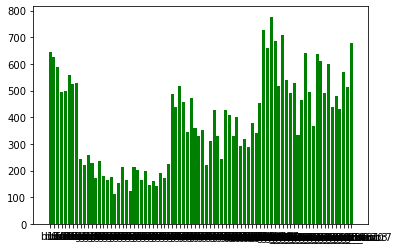

In [38]:
import numpy as np
import matplotlib.pyplot as plt
plt.bar(floors.keys(), floors.values(), color='g')

##  Let's save the aggregated result in a topic and progress from there.

In [39]:
pconf = {
    'bootstrap.servers': brokers,
       ## Your Configuration Code Here
    'key.serializer': StringSerializer('utf_8'),
    'value.serializer': IntegerSerializer()
}

In [40]:
## Your producer Code Here 
p32 = SerializingProducer(pconf)

In [49]:
try:
    for f in floors.keys():
       ## Your producering Code Here
        print(f)
#         key_string = 'building' + str(row[2])+ '_floor' + str(row[3])
#         print(key_string, row[1])
#         p3.produce(topics[1], key=key_string, value=int(row[1]))
#         p3.poll(0)
#         p3.flush()
except KeyboardInterrupt:
    sys.stderr.write('%% Aborted by user\n')

b'1'
b'6'
b'5'
b'4'
b'7'
b'0'
b'2'
b'3'
b'building0 floor1'
b'building1 floor6'
b'building2 floor1'
b'building0 floor6'
b'building0 floor5'
b'building2 floor5'
b'building1 floor5'
b'building0 floor4'
b'building2 floor6'
b'building2 floor7'
b'building1 floor0'
b'building2 floor0'
b'building1 floor4'
b'building2 floor2'
b'building0 floor3'
b'building0 floor2'
b'building2 floor4'
b'building1 floor2'
b'building2 floor3'
b'building1 floor7'
b'building1 floor1'
b'building0 floor0'
b'building1 floor3'
b'building0 floor7'
b'building0,floor1'
b'building1,floor6'
b'building2,floor1'
b'building0,floor6'
b'building0,floor5'
b'building2,floor5'
b'building1,floor5'
b'building0,floor4'
b'building2,floor6'
b'building2,floor7'
b'building1,floor0'
b'building2,floor0'
b'building1,floor4'
b'building2,floor2'
b'building0,floor3'
b'building0,floor2'
b'building2,floor4'
b'building1,floor2'
b'building2,floor3'
b'building1,floor7'
b'building1,floor1'
b'building0,floor0'
b'building1,floor3'
b'building0,floor7'


## Total number of people per building

In [29]:
## Your Consumer Code Here
consumer_conf['group.id'] = str(uuid4())
consumer_conf['value.deserializer'] = IntegerDeserializer()

c33 = DeserializingConsumer(consumer_conf)
c33.subscribe([topics[2]])

buildings = {}

In [30]:
pconf = {
    'bootstrap.servers': brokers,
    'key.serializer': StringSerializer('utf_8'),
    'value.serializer': IntegerSerializer()
}
p3 = SerializingProducer(pconf)

try:
    f = open('obs_without_header.csv', 'r')
    with f:
        reader = csv.reader(f)
        for n in range(1,1000):
            for row in reader:
            ## Your  Code Here
                key_string = 'building' + str(row[2])
                print(key_string, row[1])
                p3.produce(topics[2], key=key_string, value=int(row[1]))
                p3.poll(0)
                p3.flush()

except KeyboardInterrupt:
    sys.stderr.write('%% Aborted by user\n')

building0 5
building1 2
building2 7
building0 3
building0 8
building2 6
building1 4
building0 2
building0 4
building1 3
building0 3
building2 8
building2 6
building0 2
building2 2
building0 7
building0 0
building1 1
building2 3
building1 4
building2 9
building2 9
building1 0
building0 5
building2 1
building2 0
building0 6
building2 3
building0 0
building2 4
building0 4
building1 2
building0 6
building1 3
building0 1
building2 2
building1 0
building0 6
building2 6
building2 2
building2 9
building2 0
building0 3
building2 3
building1 0
building1 8
building2 4
building0 4
building2 0
building1 7
building0 3
building1 2
building1 1
building1 1
building1 3
building1 9
building1 0
building0 6
building2 6
building0 4
building1 6
building0 4
building2 1
building0 3
building0 1
building2 5
building0 8
building0 1
building2 5
building0 7
building1 3
building0 6
building0 5
building2 0
building0 8
building0 5
building0 2
building1 3
building1 5
building2 4
building0 5
building2 8
building0 5
buil

building1 7
building0 8
building1 4
building1 8
building0 5
building1 3
building1 6
building2 7
building2 0
building1 2
building1 9
building0 2
building1 2
building1 0
building0 5
building0 7
building1 5
building0 8
building0 5
building1 3
building1 6
building1 4
building1 3
building0 3
building2 4
building2 4
building2 2
building0 3
building0 3
building2 2
building1 3
building0 0
building0 6
building2 5
building0 0
building1 3
building2 9
building2 6
building0 0
building1 7
building1 0
building2 7
building1 0
building2 2
building0 9
building2 4
building0 9
building0 6
building1 9
building0 4
building0 1
building0 7
building1 8
building0 3
building1 0
building0 0
building2 5
building2 6
building1 4
building1 3
building1 0
building0 6
building2 4
building2 1
building2 7
building2 8
building1 0
building2 3
building1 8
building0 4
building1 1
building2 2
building2 1
building1 7
building1 8
building1 3
building2 9
building2 1
building1 4
building0 6
building0 4
building1 9
building0 3
buil

In [31]:
try:
    for i in range(1,1000):
         ## Your consuming Code Here
        msg = c33.poll(1.0)
        if msg is None:
            continue
        if msg.error():
            raise KafkaException(msg.error())
        else:
            b = msg.key()
            print(msg.key())
            print(msg.value())
            if b in buildings:
                buildings[b] = buildings[b] + msg.value()
            else:
                buildings[b] = msg.value()
            
except KeyboardInterrupt:
    sys.stderr.write('%% Aborted by user\n')

building0
5
building1
2
building2
7
building0
3
building0
8
building2
6
building1
4
building0
2
building0
4
building1
3
building0
3
building2
8
building2
6
building0
2
building2
2
building0
7
building0
0
building1
1
building2
3
building1
4
building2
9
building2
9
building1
0
building0
5
building2
1
building2
0
building0
6
building2
3
building0
0
building2
4
building0
4
building1
2
building0
6
building1
3
building0
1
building2
2
building1
0
building0
6
building2
6
building2
2
building2
9
building2
0
building0
3
building2
3
building1
0
building1
8
building2
4
building0
4
building2
0
building1
7
building0
3
building1
2
building1
1
building1
1
building1
3
building1
9
building1
0
building0
6
building2
6
building0
4
building1
6
building0
4
building2
1
building0
3
building0
1
building2
5
building0
8
building0
1
building2
5
building0
7
building1
3
building0
6
building0
5
building2
0
building0
8
building0
5
building0
2
building1
3
building1
5
building2
4
building0
5
building2
8
building0
5
buil

In [32]:
buildings

{'building0': 1642, 'building1': 1395, 'building2': 1428}

## Let's visualize the results

<BarContainer object of 3 artists>

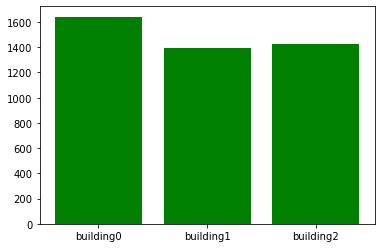

In [33]:
import numpy as np
import matplotlib.pyplot as plt
plt.bar(buildings.keys(), buildings.values(), color='g')

### Draw the dataflow between topic using a tool of choice

<!-- ![](http://placehold.it/256x256) -->
![](dataflow_simple_kafka_enlik.png)

## Optional Tasks (but useful for preparing the final examm)

## Task 4: Add a 1 minute window to the aggreagtion (see wordcount example)

## Task 5 Redo Task 0-3 modelling observations using AVRO.